In [53]:
#| include: false
#| default_exp kernels
from nbdev.showdoc import *
import numpy as np
import jax.numpy as jnp
from sklearn.metrics import pairwise_distances
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook will establish our core utilities: functions for building the diffusion matrix, with various types of kernels.

# Kernels

## Gaussian Kernel
This currently supports either a fixed bandwidth, which applies to all points, or an adaptive bandwidth, that creates a tailor-made bandwidth for each point.

### The Median Heuristic for Kernel Bandwidth
Setting the kernel bandwidth is one of the most important operations with any kernel method. It's important to have a good heuristic to avoid needing to estimate this by trial and error. This function implements the *median heuristic* described in https://arxiv.org/pdf/1707.07269.pdf.

The median heuristic sets the bandwidth to $\sqrt{H_n/2}$, where $H_n$ is the median of the squared distances between the upper triangle of the distance matrix.

In [2]:
#| export
import numpy as np
def median_heuristic(
        D:np.ndarray, # the distance matrix
):
    # estimate kernel bandwidth from distance matrix using the median heuristic
    # Get upper triangle from distance matrix (ignoring duplicates)
    h = D[np.triu_indices_from(D)]
    h = h**2
    h = np.median(h)
    nu = np.sqrt(h / 2)
    return nu

In [3]:
#| export
import numpy as np
from sklearn.metrics import pairwise_distances
def gaussian_kernel(
        X:np.ndarray, # pointcloud data as rows, shape n x d
        kernel_type = "fixed", # either fixed, or adaptive
        sigma:float = 0, # if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value
        k:float = 10, # if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor
        anisotropic_density_normalization:float = 0.5, # if nonzero, performs anisotropic density normalization
        threshold_for_small_values:float = 1e-5, # Sets all affinities below this value to zero. Set to zero to disable.
):
    """Constructs an affinity matrix from pointcloud data, using a gaussian kernel"""
    supported_kernel_types = {'fixed', 'adaptive'}
    assert kernel_type in supported_kernel_types
    D = pairwise_distances(X)
    if kernel_type == "fixed":
            if not sigma:
                # estimate sigma using a heuristic
                sigma = median_heuristic(D)
            W = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-D**2)/(2*sigma**2))
    elif kernel_type == "adaptive":
            distance_to_k_neighbor = np.partition(D,k)[:,k]
            # Populate matrices with this distance for easy division.
            div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
            div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
            # print("Distance to kth neighbors",distance_to_k_neighbor)
            # compute the gaussian kernel with an adaptive bandwidth
            W = (1/(2*np.sqrt(2*np.pi)))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
    if anisotropic_density_normalization:
        D = np.diag(1/(np.sum(W,axis=1)**anisotropic_density_normalization))
        W = D @ W @ D
    if threshold_for_small_values:
        W[W < threshold_for_small_values] = 0
    return W

In [4]:
#|export
import pygsp
def pygsp_graph_from_points(X, knn=15):
    W = gaussian_kernel(X, kernel_type="adaptive", k=knn, anisotropic_density_normalization=1)
    G = pygsp.graphs.Graph(W)
    return G

# kNN Graph

In [5]:
#|export
from sklearn.neighbors import kneighbors_graph
def knn_graph(
        X:np.ndarray,
        k = 10,
        pygsp = True,
):
    A = kneighbors_graph(X, k, mode='connectivity', include_self=True)
    if pygsp:
        G = pygsp.graphs.Graph(W)
    else:
        return A

# Diffusion Matrix

In [30]:
#| export
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from graphtools.matrix import set_diagonal

def diffusion_matrix(
        X:np.ndarray = None, # pointcloud data
        A:np.ndarray = None, # adjacency matrix, if precomputed
        kernel_type:str = "fixed", # either fixed or adaptive
        sigma = 0, # if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value
        k = 10, # if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor
        anisotropic_density_normalization = 0.5, # if nonzero, performs anisotropic density normalization
        threshold_for_small_values = 1e-5,
):
    """ Creates a diffusion matrix from pointcloud data, by row-normalizing the affinity matrix obtained from the gaussian_kernel function """
    if X is not None:
        W = gaussian_kernel(X,kernel_type,sigma=sigma,k = k,anisotropic_density_normalization = anisotropic_density_normalization, threshold_for_small_values=threshold_for_small_values)
        W = W + np.eye(len(X))*1e-5
    if X is None and A is not None:
        W = A
    
    K = set_diagonal(W, 1)
    P = normalize(W, norm="l1", axis=1)
    return P

In [31]:
show_doc(diffusion_matrix)

---

[source](https://github.com/professorwug/diffusion_curvature/blob/main/diffusion_curvature/kernels.py#L65){target="_blank" style="float:right; font-size:smaller"}

### diffusion_matrix

>      diffusion_matrix (X:numpy.ndarray=None, A:numpy.ndarray=None,
>                        kernel_type:str='fixed', sigma=0, k=10,
>                        anisotropic_density_normalization=0.5,
>                        threshold_for_small_values=1e-05)

Creates a diffusion matrix from pointcloud data, by row-normalizing the affinity matrix obtained from the gaussian_kernel function

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| X | ndarray | None | pointcloud data |
| A | ndarray | None | adjacency matrix, if precomputed |
| kernel_type | str | fixed | either fixed or adaptive |
| sigma | int | 0 | if fixed, uses kernel bandwidth sigma. If not set, uses a heuristic to estimate a good sigma value |
| k | int | 10 | if adaptive, creates a different kernel bandwidth for each point, based on the distance from that point to the kth nearest neighbor |
| anisotropic_density_normalization | float | 0.5 | if nonzero, performs anisotropic density normalization |
| threshold_for_small_values | float | 1e-05 |  |

# Exploration of different kernel functions

In [32]:
X = np.random.rand(5,5)
D = pairwise_distances(X)
D

array([[0.        , 0.78188799, 0.60583067, 0.49499488, 0.9122873 ],
       [0.78188799, 0.        , 0.7906655 , 0.58159086, 1.03574143],
       [0.60583067, 0.7906655 , 0.        , 0.73911112, 1.24534694],
       [0.49499488, 0.58159086, 0.73911112, 0.        , 0.76532126],
       [0.9122873 , 1.03574143, 1.24534694, 0.76532126, 0.        ]])

In [33]:
# Get the distance to the kth closest neighbor
distance_to_k_neighbor = np.partition(D,2)[:,2]
# [:,2] # argpartition is more efficient than argsort ([python - How to get indices of top-K values from a numpy array - Stack Overflow](https://stackoverflow.com/questions/65038206/how-to-get-indices-of-top-k-values-from-a-numpy-array))
distance_to_k_neighbor

array([0.60583067, 0.78188799, 0.73911112, 0.58159086, 0.9122873 ])

Double checking that the code for the adaptive kernel works as intended:

In [34]:
div2 = distance_to_k_neighbor[:,None] @ np.ones(len(D))[None,:]
div2

array([[0.60583067, 0.60583067, 0.60583067, 0.60583067, 0.60583067],
       [0.78188799, 0.78188799, 0.78188799, 0.78188799, 0.78188799],
       [0.73911112, 0.73911112, 0.73911112, 0.73911112, 0.73911112],
       [0.58159086, 0.58159086, 0.58159086, 0.58159086, 0.58159086],
       [0.9122873 , 0.9122873 , 0.9122873 , 0.9122873 , 0.9122873 ]])

In [35]:
div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
div1

array([[0.60583067, 0.78188799, 0.73911112, 0.58159086, 0.9122873 ],
       [0.60583067, 0.78188799, 0.73911112, 0.58159086, 0.9122873 ],
       [0.60583067, 0.78188799, 0.73911112, 0.58159086, 0.9122873 ],
       [0.60583067, 0.78188799, 0.73911112, 0.58159086, 0.9122873 ],
       [0.60583067, 0.78188799, 0.73911112, 0.58159086, 0.9122873 ]])

Let's chart the torus with several different diffusion kernels.

In [36]:
from diffusion_curvature.datasets import torus

In [37]:
X, ks = torus(n=2000)

In [38]:
X

array([[-1.83093188,  2.37403251, -0.0623178 ],
       [ 0.3479158 , -1.08940853, -0.51633859],
       [ 0.57513824,  2.90472742, -0.2761347 ],
       ...,
       [-1.03643016,  1.98337076, -0.9713033 ],
       [-0.73772236, -2.89285605, -0.17002506],
       [-1.92007715,  1.73488329, -0.80903331]])

To visualize this, we'll build a 3D plot helper, to save time in the future

In [39]:
#| export
# For plotting 2D and 3D graphs
import plotly
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def plot_3d(X,distribution=None, title="",lim=None,use_plotly=False, zlim = None, colorbar = False, cmap="plasma"):
    if distribution is None:
        distribution = np.zeros(len(X))
    if lim is None:
        lim = np.max(np.linalg.norm(X,axis=1))
    if zlim is None:
        zlim = lim
    if use_plotly:
        d = {'x':X[:,0],'y':X[:,1],'z':X[:,2],'colors':distribution}
        df = pd.DataFrame(data=d)
        fig = px.scatter_3d(df, x='x',y='y',z='z',color='colors', title=title, range_x=[-lim,lim], range_y=[-lim,lim],range_z=[-zlim,zlim])
        fig.show()
    else:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111,projection='3d')
        ax.axes.set_xlim3d(left=-lim, right=lim)
        ax.axes.set_ylim3d(bottom=-lim, top=lim)
        ax.axes.set_zlim3d(bottom=-zlim, top=zlim)
        im = ax.scatter(X[:,0],X[:,1],X[:,2],c=distribution,cmap=cmap)
        ax.set_title(title)
        if colorbar: fig.colorbar(im, ax=ax)
        plt.show()

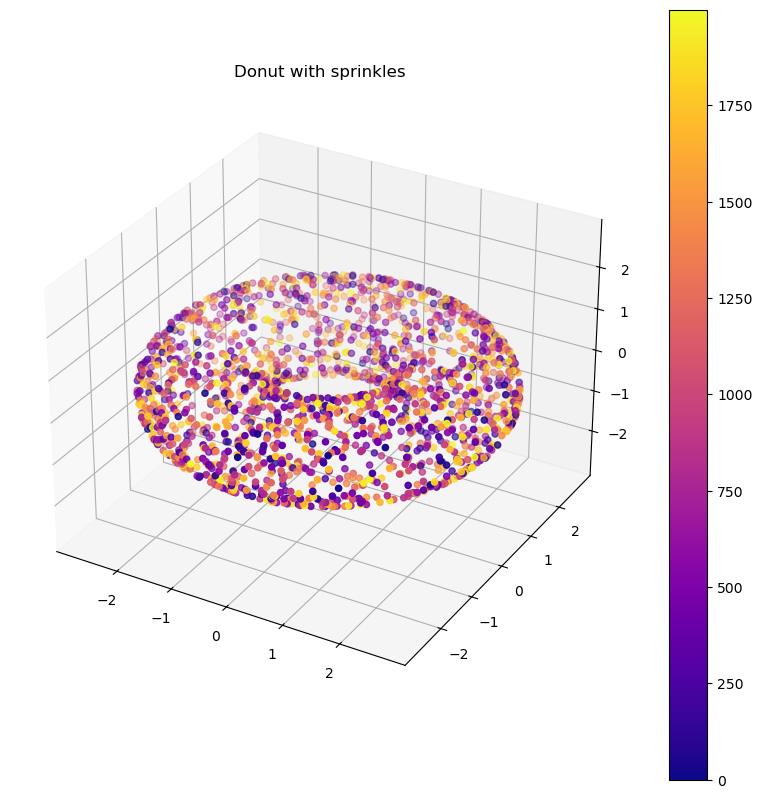

In [40]:
plot_3d(X,list(range(len(X))),"Donut with sprinkles",colorbar = True)

Hurrah! Our donut is intact, and our plotting function is working as expected.

Now let's visualize some diffusions, under various kernels.

## The Adaptive Kernel

Here we have the adaptive kernel born Diffusion matrix, and we visualize the diffusion centered on the point (0,-3,0), which (from the view of the plot below), should be on the outer rim of the torus, facing us directly.

In [41]:
P = diffusion_matrix(X,kernel_type="adaptive",k=20)

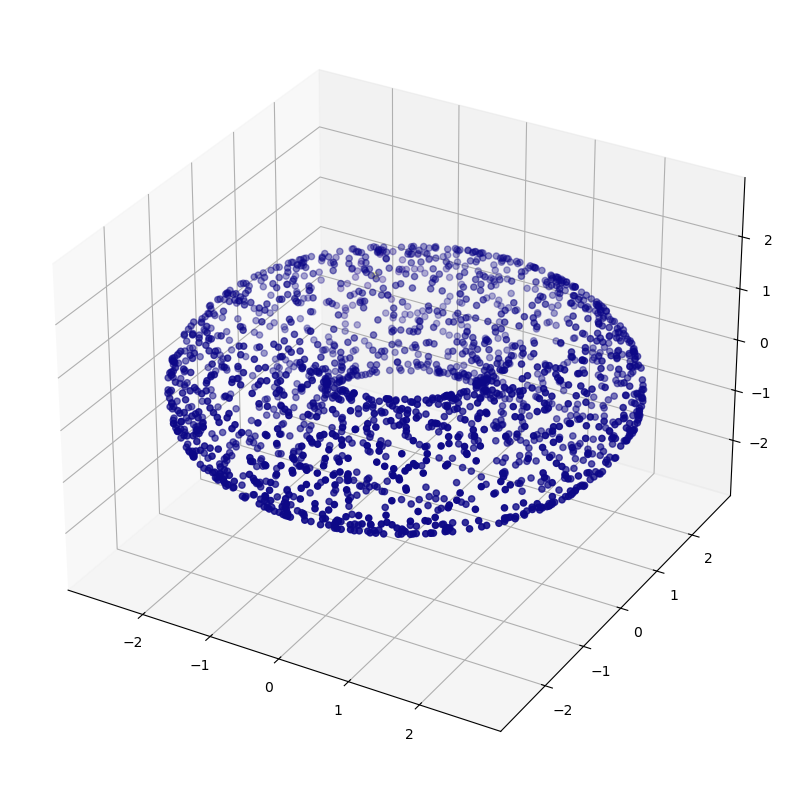

In [42]:
dist = P[0]
plot_3d(X,dist)

## The Adaptive Anisotropic Kernel

Now we'll add one more round of density normalization with the "adaptive anisotropic" kernel:
$$ W_{a} = D^{-1} W D^{-1} $$
Where D is the matrix whose diagonals are the rowsums of W.

In [43]:
P = diffusion_matrix(X,kernel_type="adaptive",k=20,anisotropic_density_normalization=1)

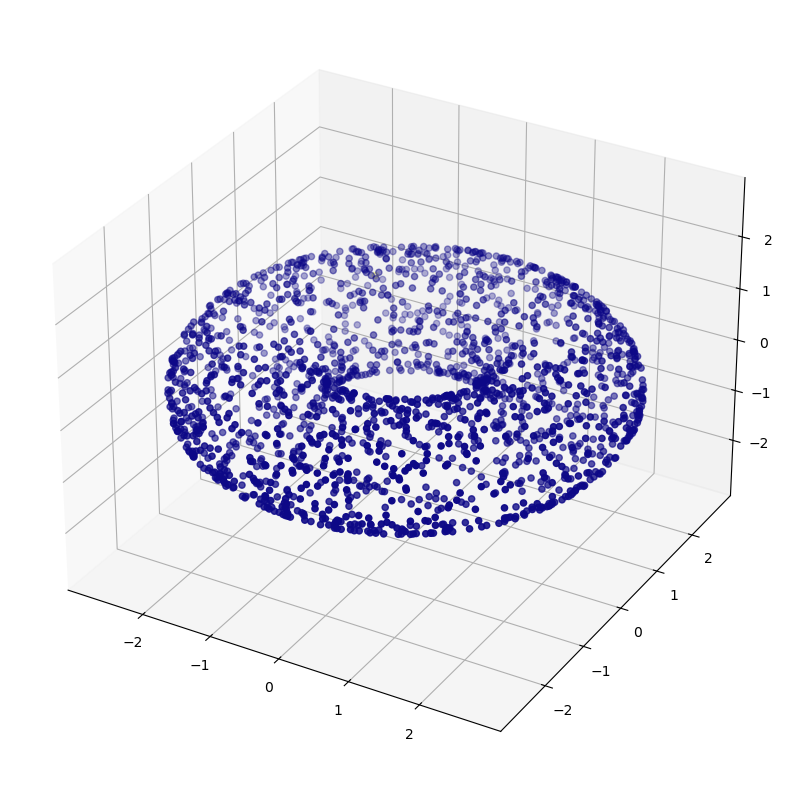

In [44]:
dist = P[0]
plot_3d(X,dist)

It looks much the same, as expected. Ideally, this kernel will combat density related differences in the curvature, by equalizing the density.

In [45]:
from diffusion_curvature.datasets import sphere

In [46]:
X, ks = sphere(2000)

In [47]:
A = gaussian_kernel(X,kernel_type = "adaptive", k = 10, anisotropic_density_normalization = 1, threshold_for_small_values=1e-5)

In [48]:
A

array([[0.00102873, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00085635, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00079775, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00086877, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0009022 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00063627]])

In [49]:
sum(A)

array([0.01593725, 0.01654875, 0.01803043, ..., 0.01560873, 0.01835663,
       0.0159891 ])

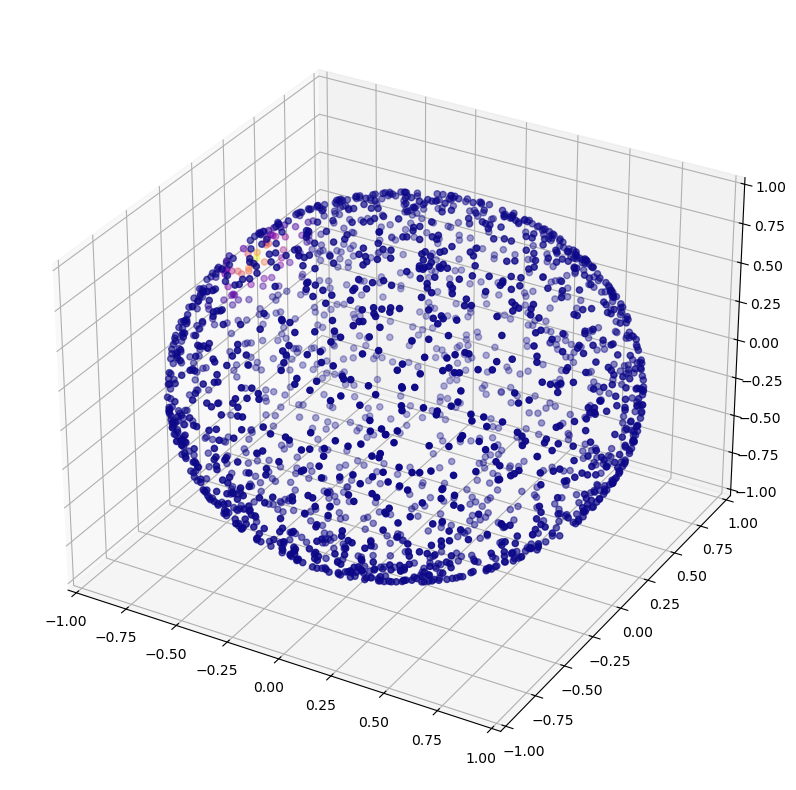

In [50]:
plot_3d(X,A[0])

In [51]:
#| export
import numpy as np
def compute_anisotropic_affinities_from_graph(
    A:np.ndarray, # the adjacency/affinity matrix of the graph
    alpha:float, # the anisotropic density normalization parameter
) -> np.ndarray:
    # normalize by density
    D = np.diag(1/np.sum(A,axis=1)**alpha)
    A_anis = D @ A @ D
    return A_anis

def compute_anisotropic_diffusion_matrix_from_graph(
    A:np.ndarray, # the adjacency/affinity matrix of the graph
    alpha:float, # the anisotropic density normalization parameter
    ) -> np.ndarray:
    A_anis = compute_anisotropic_affinities_from_graph(A,alpha)
    # row normalize to create diffusion matrix
    D = np.diag(1/(np.sum(A_anis,axis=1)+1e-8))
    P = D @ A_anis
    return P

# Testing

## kNN Graph

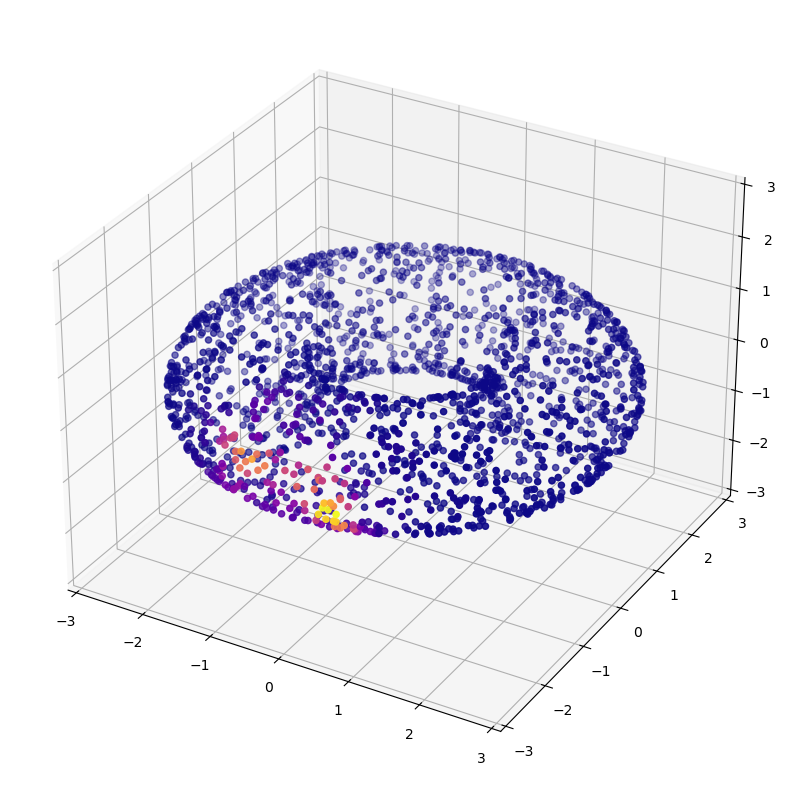

In [64]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.heat_diffusion import jax_power_matrix
X, ks = torus(2000, use_guide_points = True)
A = knn_graph(X,k=10, pygsp=False)
P = diffusion_matrix(A = A).todense()
Pt = jax_power_matrix(jnp.asarray(P),20)
plot_3d(X, Pt[0])

In [58]:
P

<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 20000 stored elements in Compressed Sparse Row format>

In [ ]:
!nbdev_export

In [ ]:
show_doc(torus)